In [56]:
import os
import glob
import numpy as np
from utils.utils import group_weekly
import warnings
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

SurfacePressure -> Wind, Temperature, Migration <br/>
Wind -> Humidity, CloudCoverage <br/>
Temperature -> Humidity, CloudCoverage, NDVI <br/>
Humidity -> Rain, NDVI <br/>
CloudCoverage -> Rain, NDVI <br/>
Rain -> NDVI <br/>
Longitude -> Temperature, Wind, SurfacePressure <br/>
Latitude -> Temperature, Wind, SurfacePressure <br/>
NDVI -> Migration <br/>

### Load and concatenate data

In [57]:
concatenated_df = pd.DataFrame()

# Iterate over files in the folder
for file_path in glob.glob(os.path.join('data', 'StorkMigrationWithNDVIWeather*.csv')):
    data = pd.read_csv(file_path)
    if 'Unnamed: 0' in data.columns:
        data = data.drop(['Unnamed: 0'],axis=1)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    result_data = group_weekly(data)
    concatenated_df = pd.concat([concatenated_df, result_data])

print(concatenated_df.shape)
concatenated_df.to_csv(os.path.join('data','GrouppedByData.csv'))
print('Csv file created')
concatenated_df['timestamp']=pd.to_datetime(concatenated_df['timestamp'])
concatenated_df = concatenated_df.dropna()
copy_concatenated_df = concatenated_df.copy()

1
2301
(16670, 11)
(14, 13)
2
2301
(18034, 11)
2303
(2558, 11)
(17, 13)
2
2305
(6415, 11)
2303
(8337, 11)
(14, 13)
1
2305
(3125, 11)
(7, 13)
2
2305
(8862, 11)
2306
(4573, 11)
(12, 13)
1
1791
(16586, 11)
(16, 13)
2
1793
(14893, 11)
1791
(2135, 11)
(17, 13)
2
1793
(9435, 11)
1794
(1208, 11)
(18, 13)
1
1794
(14465, 11)
(14, 13)
2
1794
(2989, 11)
1796
(12288, 11)
(18, 13)
2
1796
(3869, 11)
1797
(9717, 11)
(14, 13)
2
2301
(1238, 11)
1797
(12754, 11)
(16, 13)
1
2301
(19091, 11)
(15, 13)
2
1787
(7479, 11)
1791
(15049, 11)
(20, 13)
(212, 13)
Csv file created


In [58]:
display(concatenated_df.head())

,tag-local-identifier,timestamp,NDVI,temperature_2m,relative_humidity_2m,rain,surface_pressure,cloud_cover,wind_speed_100m,distance-flown,location-lat,location-long,distance-traveled
1,2301,2014-04-07,1.000000,27.166506,75.406218,0.0,1012.119917,19.424948,17.504099,190.006150,52.939327,11.787121,80.332094
2,2301,2014-04-14,1.000000,27.296474,72.291403,0.0,1013.621793,5.509615,9.664323,8.633323,52.939315,11.787140,0.001848
3,2301,2015-01-26,0.311800,7.368060,31.763185,0.0,912.871041,1.088406,15.018297,4867.366319,11.628961,25.130908,4734.574226
4,2301,2015-02-02,0.276642,10.896092,30.919514,0.0,915.741864,5.623704,17.692069,935.171770,11.499063,24.830863,35.742784
5,2301,2015-02-09,0.189800,16.451284,18.642753,0.0,929.048683,4.644090,21.572337,1119.210112,11.238312,27.654547,309.548916


In [59]:
result = concatenated_df.groupby('tag-local-identifier').agg({'timestamp': ['count', 'min', 'max']}).reset_index()

# Rename columns for clarity
result.columns = ['value', 'count', 'min_timestamp', 'max_timestamp']

display(result)

,value,count,min_timestamp,max_timestamp
0,1787,7,2013-03-11,2013-04-22
1,1791,28,2013-03-11,2015-04-20
2,1793,28,2013-03-11,2015-04-13
3,1794,17,2013-03-11,2014-04-14
4,1796,18,2013-03-11,2014-04-07
5,1797,20,2014-02-10,2015-04-13
6,2301,41,2013-03-11,2016-04-11
7,2303,9,2013-03-11,2013-05-06
8,2305,18,2013-03-11,2014-04-07
9,2306,3,2013-03-11,2013-03-25


### Data Discretization

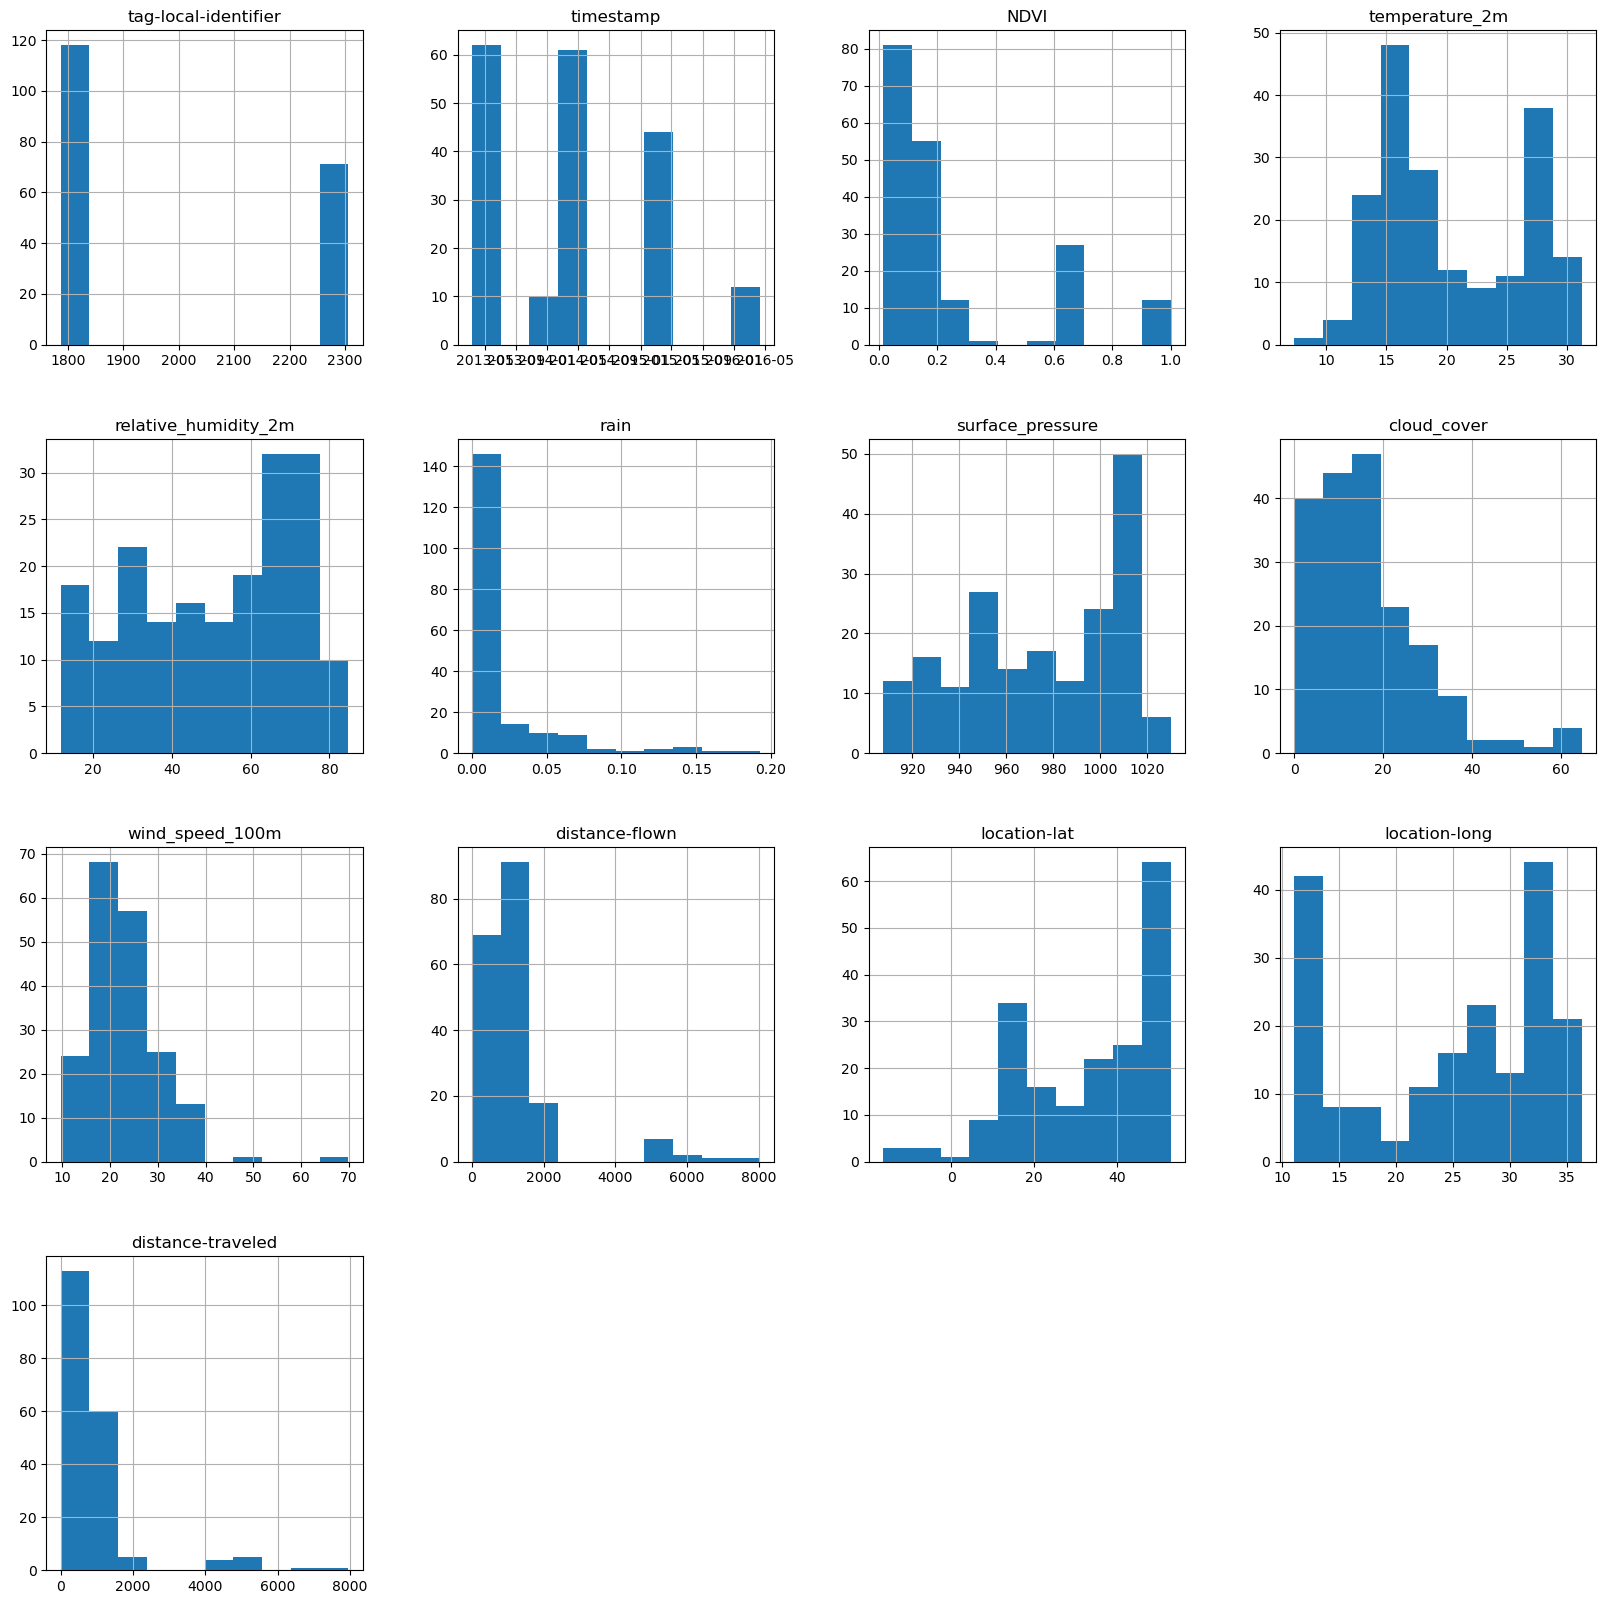

In [60]:
concatenated_df.hist(figsize=(20,20))
plt.show()

Explain dropped columns and why

In [108]:
concatenated_df = copy_concatenated_df.copy()
print(concatenated_df.columns)

Index(['tag-local-identifier', 'timestamp', 'NDVI', 'temperature_2m',
       'relative_humidity_2m', 'rain', 'surface_pressure', 'cloud_cover',
       'wind_speed_100m', 'distance-flown', 'location-lat', 'location-long',
       'distance-traveled'],
      dtype='object')


In [109]:
concatenated_df = concatenated_df.drop(['distance-flown'],axis=1)
new_column_names = ['Stork_id', 'Timestamp', 'NDVI', 'Temperature', 'RelativeHumidity', 'Rain', 'SurfacePressure', 'CloudCover', 'WindSpeed',
                    'LastLatitude', 'LastLongitude','Migrating']
concatenated_df.columns = new_column_names
concatenated_df = concatenated_df.round(4)
display(concatenated_df.head())

,Stork_id,Timestamp,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,LastLatitude,LastLongitude,Migrating
1,2301,2014-04-07,1.0000,27.1665,75.4062,0.0,1012.1199,19.4249,17.5041,52.9393,11.7871,80.3321
2,2301,2014-04-14,1.0000,27.2965,72.2914,0.0,1013.6218,5.5096,9.6643,52.9393,11.7871,0.0018
3,2301,2015-01-26,0.3118,7.3681,31.7632,0.0,912.8710,1.0884,15.0183,11.6290,25.1309,4734.5742
4,2301,2015-02-02,0.2766,10.8961,30.9195,0.0,915.7419,5.6237,17.6921,11.4991,24.8309,35.7428
5,2301,2015-02-09,0.1898,16.4513,18.6428,0.0,929.0487,4.6441,21.5723,11.2383,27.6545,309.5489


In [110]:
# concatenated_df is assumed to be defined elsewhere in your code

# Specify the columns you want to discretize
columns_to_discretize = [ 'NDVI', 'Temperature', 'RelativeHumidity', 'Rain', 'SurfacePressure', 'CloudCover', 'WindSpeed','Migrating']
# Specify the number of bin
number_of_bins = [2,3,2,2,2,2,2,2]

# Reset the index of concatenated_df to avoid duplicate index values
concatenated_df.reset_index(drop=True, inplace=True)

bin_names_dictionary = dict()

# Sort DataFrame by the column you are discretizing
for i in range(0,len(columns_to_discretize)):
    column = columns_to_discretize[i]
    num_bins = number_of_bins[i]
    bin_names_dictionary[column] = {}
    
    # Sort DataFrame by the column
    df_sorted = concatenated_df.sort_values(by=column)
    
    # Discretize values into bins with equal number of records
    discretized_column, bin_edges = pd.qcut(df_sorted[column], q=num_bins, labels=False, duplicates='drop', retbins=True)

    # Create a DataFrame containing the discretized values and bin edges
    result_table = pd.DataFrame({
        'Bin_edge_low_' + column: bin_edges[:-1],
        'Bin_edge_high_' + column: bin_edges[1:]
    })  # Use the same index as the sorted DataFrame

    for ind,row in result_table[:-1].iterrows():
        bin_names_dictionary[column][ind]=f'< {round(row[f"Bin_edge_high_" + column],2)}'
    bin_names_dictionary[column][ind]=f'> {round(result_table.iloc[-1][f"Bin_edge_low_" + column],2)}'
    # Write dictionary string to a text file
    with open(os.path.join('data','Labels_dictionary_for discretization.txt'), 'w') as file:
        file.write(str(bin_names_dictionary))
    display(result_table)
    
    # Merge result_table with the original DataFrame to retain other columns
    concatenated_df[column] = discretized_column


display(concatenated_df.head())

,Bin_edge_low_NDVI,Bin_edge_high_NDVI
0,0.0149,0.1674
1,0.1674,1.0000


,Bin_edge_low_Temperature,Bin_edge_high_Temperature
0,7.368100,16.186300
1,16.186300,24.187067
2,24.187067,31.220500


,Bin_edge_low_RelativeHumidity,Bin_edge_high_RelativeHumidity
0,11.7135,54.9564
1,54.9564,84.7962


,Bin_edge_low_Rain,Bin_edge_high_Rain
0,0.0000,0.0016
1,0.0016,0.1923


,Bin_edge_low_SurfacePressure,Bin_edge_high_SurfacePressure
0,907.6792,979.4087
1,979.4087,1030.1427


,Bin_edge_low_CloudCover,Bin_edge_high_CloudCover
0,0.0000,14.0503
1,14.0503,64.8263


,Bin_edge_low_WindSpeed,Bin_edge_high_WindSpeed
0,9.6643,21.8431
1,21.8431,69.8538


,Bin_edge_low_Migrating,Bin_edge_high_Migrating
0,0.0011,702.1281
1,702.1281,7951.8811


,Stork_id,Timestamp,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,LastLatitude,LastLongitude,Migrating
0,2301,2014-04-07,1,2,1,0,1,1,0,52.9393,11.7871,0
1,2301,2014-04-14,1,2,1,0,1,0,0,52.9393,11.7871,0
2,2301,2015-01-26,1,0,0,0,0,0,0,11.6290,25.1309,1
3,2301,2015-02-02,1,0,0,0,0,0,0,11.4991,24.8309,0
4,2301,2015-02-09,1,1,0,0,0,0,0,11.2383,27.6545,0


In [111]:
display(bin_names_dictionary)

{'NDVI': {0: '> 0.17'},
 'Temperature': {0: '< 16.19', 1: '> 24.19'},
 'RelativeHumidity': {0: '> 54.96'},
 'Rain': {0: '> 0.0'},
 'SurfacePressure': {0: '> 979.41'},
 'CloudCover': {0: '> 14.05'},
 'WindSpeed': {0: '> 21.84'},
 'Migrating': {0: '> 702.13'}}

### Transform for Dynamic Bayesian Network (DBN)

Insert type of format needed

In [112]:
for stork_id in concatenated_df['Stork_id'].unique().tolist():
    print(stork_id)
    subdata = concatenated_df[concatenated_df['Stork_id']==stork_id]
    subdata['Timestamp'] = pd.to_datetime(subdata['Timestamp'])

    # Create a new column 'order' containing the ordered indices
    subdata['Order'] = subdata['Timestamp'].rank(method='first').astype(int) - 1

    # Sort DataFrame by 'timestamp_column'
    subdata = subdata.sort_values(by='Timestamp')

    # Reset index to maintain consistency (optional)
    subdata = subdata.drop(['Timestamp','Stork_id'],axis=1)
    subdata = subdata.reset_index(drop=True)
    display(subdata.head())
    flattened_data = subdata.apply(lambda row: ','.join(map(str, row)), axis=1)
    print(flattened_data)

2301


,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,LastLatitude,LastLongitude,Migrating,Order
0,0,0,1,0,1,0,1,27.5031,33.4104,0,0
1,0,1,0,1,0,0,1,44.1087,27.4584,1,1
2,0,1,0,1,0,0,1,46.9638,23.6233,0,2
3,0,2,0,0,0,0,0,47.2895,23.3688,0,3
4,1,2,0,0,0,0,1,51.1120,17.1681,0,4


0     0.0,0.0,1.0,0.0,1.0,0.0,1.0,27.5031,33.4104,0....
1     0.0,1.0,0.0,1.0,0.0,0.0,1.0,44.1087,27.4584,1....
2     0.0,1.0,0.0,1.0,0.0,0.0,1.0,46.9638,23.6233,0....
3     0.0,2.0,0.0,0.0,0.0,0.0,0.0,47.2895,23.3688,0....
4     1.0,2.0,0.0,0.0,0.0,0.0,1.0,51.112,17.1681,0.0...
5     1.0,2.0,1.0,1.0,1.0,1.0,0.0,52.9393,11.7872,0....
6     1.0,2.0,1.0,0.0,1.0,0.0,0.0,52.9393,11.7872,0....
7     0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.0174,26.4997,1....
8     0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0354,26.3322,0....
9     0.0,1.0,0.0,0.0,0.0,0.0,1.0,12.1528,29.051,0.0...
10    0.0,0.0,1.0,1.0,1.0,1.0,1.0,18.6121,31.8114,1....
11    0.0,0.0,1.0,1.0,1.0,1.0,0.0,27.5554,33.4042,1....
12    0.0,0.0,1.0,1.0,0.0,1.0,0.0,38.3556,31.6347,1....
13    0.0,1.0,0.0,1.0,0.0,0.0,1.0,43.3831,25.1162,1....
14    0.0,1.0,0.0,0.0,0.0,0.0,0.0,44.9599,22.7174,0....
15    1.0,2.0,1.0,0.0,1.0,1.0,0.0,52.9393,11.7871,0....
16    1.0,2.0,1.0,0.0,1.0,0.0,0.0,52.9393,11.7871,0....
17    1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.629,25.1309

,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,LastLatitude,LastLongitude,Migrating,Order
0,0,2,0,0,0,0,0,15.2646,23.1463,0,0
1,0,2,0,0,0,0,0,15.7333,24.0045,0,1
2,0,1,0,0,1,0,1,28.6233,32.5956,1,2
3,0,1,1,1,1,1,1,32.0568,35.5151,0,3
4,1,1,0,0,0,0,0,39.2987,34.0688,1,4


0    0.0,2.0,0.0,0.0,0.0,0.0,0.0,15.2646,23.1463,0....
1    0.0,2.0,0.0,0.0,0.0,0.0,0.0,15.7333,24.0045,0....
2    0.0,1.0,0.0,0.0,1.0,0.0,1.0,28.6233,32.5956,1....
3    0.0,1.0,1.0,1.0,1.0,1.0,1.0,32.0568,35.5151,0....
4    1.0,1.0,0.0,0.0,0.0,0.0,0.0,39.2987,34.0688,1....
5    1.0,1.0,0.0,0.0,0.0,0.0,1.0,43.3512,25.1865,1....
6    1.0,2.0,0.0,1.0,0.0,0.0,0.0,51.283,12.2002,1.0...
7    1.0,2.0,1.0,1.0,1.0,0.0,0.0,52.1056,12.1043,0....
8    1.0,2.0,1.0,0.0,1.0,1.0,0.0,52.1056,12.1043,0....
dtype: object
2305


,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,LastLatitude,LastLongitude,Migrating,Order
0,0,1,1,1,1,1,1,22.8806,32.8386,1,0
1,0,1,1,1,1,1,1,32.6284,35.5689,1,1
2,0,1,0,1,1,1,0,37.0899,34.6927,0,2
3,0,1,0,1,0,0,1,44.0671,25.6541,1,3
4,1,2,0,0,0,0,1,47.2963,20.5944,0,4


0     0.0,1.0,1.0,1.0,1.0,1.0,1.0,22.8806,32.8386,1....
1     0.0,1.0,1.0,1.0,1.0,1.0,1.0,32.6284,35.5689,1....
2     0.0,1.0,0.0,1.0,1.0,1.0,0.0,37.0899,34.6927,0....
3     0.0,1.0,0.0,1.0,0.0,0.0,1.0,44.0671,25.6541,1....
4     1.0,2.0,0.0,0.0,0.0,0.0,1.0,47.2963,20.5944,0....
5     1.0,2.0,0.0,0.0,0.0,0.0,0.0,52.5604,11.0737,0....
6     1.0,2.0,1.0,0.0,1.0,0.0,0.0,52.5604,11.0737,0....
7     1.0,0.0,1.0,0.0,1.0,0.0,1.0,-3.4556,35.8494,1....
8     1.0,0.0,1.0,1.0,1.0,1.0,1.0,-3.4527,35.8393,0....
9     0.0,0.0,1.0,1.0,1.0,1.0,1.0,-3.0702,36.149,0.0...
10    0.0,0.0,1.0,1.0,0.0,1.0,1.0,4.0063,34.5918,1.0...
11    0.0,1.0,1.0,1.0,1.0,1.0,1.0,18.0437,32.2594,1....
12    0.0,0.0,0.0,1.0,1.0,1.0,1.0,24.6798,32.8994,1....
13    0.0,1.0,1.0,1.0,1.0,1.0,1.0,37.5131,35.6146,1....
14    0.0,0.0,1.0,1.0,0.0,1.0,1.0,41.1493,29.3739,0....
15    0.0,1.0,0.0,1.0,0.0,1.0,1.0,42.5875,27.4844,0....
16    0.0,1.0,0.0,1.0,0.0,0.0,0.0,52.5604,11.0738,1....
17    1.0,2.0,1.0,0.0,1.0,1.0,0.0,52.5604,11.073

,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,LastLatitude,LastLongitude,Migrating,Order
0,0,0,1,1,0,1,1,13.4802,33.5567,1,0
1,0,0,1,1,1,1,1,25.5023,33.1960,1,1
2,0,1,1,1,1,1,1,32.9879,35.7458,1,2


0    0.0,0.0,1.0,1.0,0.0,1.0,1.0,13.4802,33.5567,1....
1    0.0,0.0,1.0,1.0,1.0,1.0,1.0,25.5023,33.196,1.0...
2    0.0,1.0,1.0,1.0,1.0,1.0,1.0,32.9879,35.7458,1....
dtype: object
1791


,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,LastLatitude,LastLongitude,Migrating,Order
0,0,0,1,1,1,1,0,37.0572,35.4082,1,0
1,0,1,0,0,0,0,1,43.3530,27.0322,1,1
2,0,1,0,1,0,0,1,47.7047,23.3279,0,2
3,0,2,0,0,0,0,0,51.2370,16.1782,0,3
4,1,2,1,0,1,1,0,52.9416,11.7837,0,4


0     0.0,0.0,1.0,1.0,1.0,1.0,0.0,37.0572,35.4082,1....
1     0.0,1.0,0.0,0.0,0.0,0.0,1.0,43.353,27.0322,1.0...
2     0.0,1.0,0.0,1.0,0.0,0.0,1.0,47.7047,23.3279,0....
3     0.0,2.0,0.0,0.0,0.0,0.0,0.0,51.237,16.1782,0.0...
4     1.0,2.0,1.0,0.0,1.0,1.0,0.0,52.9416,11.7837,0....
5     1.0,2.0,1.0,1.0,1.0,1.0,0.0,52.9415,11.7837,0....
6     1.0,0.0,0.0,1.0,0.0,1.0,1.0,11.1434,26.8216,1....
7     0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.1526,26.5643,0....
8     0.0,0.0,0.0,0.0,1.0,0.0,1.0,14.4928,32.3704,1....
9     0.0,0.0,1.0,1.0,1.0,1.0,1.0,23.9986,32.9512,1....
10    0.0,0.0,1.0,0.0,1.0,1.0,0.0,26.3547,33.3258,0....
11    0.0,1.0,1.0,1.0,1.0,1.0,1.0,37.5829,33.71,0.0,...
12    0.0,0.0,0.0,1.0,0.0,1.0,1.0,43.04,26.4102,1.0,...
13    0.0,2.0,0.0,1.0,0.0,0.0,0.0,49.7317,15.6478,1....
14    0.0,2.0,1.0,0.0,1.0,0.0,0.0,52.9415,11.7837,0....
15    1.0,2.0,1.0,0.0,1.0,1.0,0.0,52.9415,11.7836,0....
16    1.0,0.0,0.0,0.0,0.0,1.0,0.0,11.4983,25.2048,1....
17    1.0,1.0,0.0,0.0,0.0,0.0,0.0,11.1928,25.121

,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,LastLatitude,LastLongitude,Migrating,Order
0,0,1,1,0,1,0,1,19.7848,31.8751,1,0
1,0,0,1,1,1,1,1,32.9099,35.7909,1,1
2,0,0,1,1,1,1,1,32.9077,35.7919,0,2
3,0,1,1,1,1,1,1,39.0078,33.8769,0,3
4,1,1,0,0,0,0,1,41.2121,28.8801,0,4


0     0.0,1.0,1.0,0.0,1.0,0.0,1.0,19.7848,31.8751,1....
1     0.0,0.0,1.0,1.0,1.0,1.0,1.0,32.9099,35.7909,1....
2     0.0,0.0,1.0,1.0,1.0,1.0,1.0,32.9077,35.7919,0....
3     0.0,1.0,1.0,1.0,1.0,1.0,1.0,39.0078,33.8769,0....
4     1.0,1.0,0.0,0.0,0.0,0.0,1.0,41.2121,28.8801,0....
5     1.0,2.0,0.0,0.0,0.0,0.0,1.0,50.1469,20.6061,1....
6     1.0,2.0,1.0,1.0,1.0,0.0,1.0,52.9204,11.8712,0....
7     1.0,2.0,1.0,1.0,1.0,0.0,0.0,52.9204,11.8712,0....
8     0.0,0.0,1.0,1.0,1.0,1.0,1.0,-16.459,33.0506,1....
9     0.0,1.0,1.0,0.0,1.0,1.0,1.0,-16.4684,33.0396,0...
10    0.0,0.0,1.0,1.0,1.0,1.0,0.0,-9.8273,32.8746,1....
11    0.0,0.0,1.0,1.0,0.0,1.0,0.0,5.0814,33.0399,1.0...
12    0.0,1.0,1.0,0.0,1.0,0.0,0.0,13.8119,32.905,1.0...
13    0.0,1.0,1.0,0.0,1.0,0.0,1.0,28.2582,33.1044,1....
14    1.0,1.0,1.0,1.0,1.0,1.0,0.0,31.7239,35.2732,0....
15    1.0,1.0,0.0,1.0,0.0,1.0,1.0,42.5172,26.7419,1....
16    1.0,2.0,0.0,1.0,0.0,1.0,0.0,47.7846,21.5662,1....
17    1.0,2.0,0.0,0.0,1.0,1.0,0.0,52.9203,11.871

,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,LastLatitude,LastLongitude,Migrating,Order
0,0,1,0,0,0,0,1,18.0144,27.4689,0,0
1,0,0,1,1,1,1,1,36.2757,36.3581,1,1
2,0,1,0,1,0,1,0,41.1491,29.3726,1,2
3,1,2,0,1,0,0,0,46.4617,24.1263,1,3
4,1,2,0,0,0,0,1,50.7269,16.0786,1,4


0     0.0,1.0,0.0,0.0,0.0,0.0,1.0,18.0144,27.4689,0....
1     0.0,0.0,1.0,1.0,1.0,1.0,1.0,36.2757,36.3581,1....
2     0.0,1.0,0.0,1.0,0.0,1.0,0.0,41.1491,29.3726,1....
3     1.0,2.0,0.0,1.0,0.0,0.0,0.0,46.4617,24.1263,1....
4     1.0,2.0,0.0,0.0,0.0,0.0,1.0,50.7269,16.0786,1....
5     1.0,2.0,1.0,0.0,1.0,1.0,0.0,51.7084,12.8707,0....
6     1.0,2.0,1.0,0.0,1.0,0.0,1.0,51.7084,12.8707,0....
7     0.0,1.0,0.0,0.0,0.0,0.0,1.0,12.1641,15.6418,1....
8     0.0,1.0,0.0,0.0,0.0,0.0,1.0,12.2604,15.7377,0....
9     0.0,1.0,0.0,0.0,0.0,0.0,1.0,15.6901,23.0969,1....
10    0.0,1.0,0.0,0.0,0.0,1.0,1.0,17.4186,27.9669,0....
11    0.0,0.0,0.0,1.0,1.0,1.0,0.0,24.346,33.0362,1.0...
12    0.0,0.0,1.0,1.0,1.0,1.0,1.0,33.1312,35.5699,1....
13    0.0,0.0,1.0,0.0,0.0,0.0,0.0,38.4893,31.3287,1....
14    0.0,1.0,0.0,1.0,0.0,0.0,0.0,51.3856,13.4767,1....
15    1.0,2.0,1.0,0.0,1.0,0.0,1.0,51.7084,12.8706,0....
16    1.0,2.0,1.0,0.0,1.0,0.0,0.0,51.7084,12.8707,0....
dtype: object
1796


,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,LastLatitude,LastLongitude,Migrating,Order
0,0,1,1,1,1,1,1,29.7296,33.6350,1,0
1,0,1,0,1,0,1,1,43.7950,28.1603,1,1
2,0,1,0,1,0,1,0,46.2085,27.6662,0,2
3,0,2,0,1,0,0,0,46.1943,27.6558,0,3
4,1,2,0,1,0,0,1,45.6888,27.2658,0,4


0     0.0,1.0,1.0,1.0,1.0,1.0,1.0,29.7296,33.635,1.0...
1     0.0,1.0,0.0,1.0,0.0,1.0,1.0,43.795,28.1603,1.0...
2     0.0,1.0,0.0,1.0,0.0,1.0,0.0,46.2085,27.6662,0....
3     0.0,2.0,0.0,1.0,0.0,0.0,0.0,46.1943,27.6558,0....
4     1.0,2.0,0.0,1.0,0.0,0.0,1.0,45.6888,27.2658,0....
5     1.0,2.0,0.0,0.0,0.0,0.0,0.0,52.4985,13.8676,1....
6     1.0,2.0,1.0,1.0,1.0,0.0,0.0,52.8804,11.8252,0....
7     1.0,2.0,1.0,1.0,1.0,0.0,1.0,52.8805,11.8253,0....
8     1.0,0.0,0.0,1.0,0.0,1.0,1.0,11.4802,26.42,1.0,8.0
9     0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.7865,26.6156,0....
10    0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.3121,30.232,0.0...
11    0.0,1.0,1.0,1.0,1.0,1.0,1.0,21.4748,32.5392,1....
12    0.0,0.0,1.0,1.0,1.0,1.0,0.0,23.6553,32.4822,0....
13    0.0,1.0,0.0,1.0,0.0,1.0,1.0,38.6114,30.8769,1....
14    0.0,1.0,0.0,1.0,0.0,0.0,1.0,42.0863,23.0634,1....
15    0.0,2.0,0.0,0.0,0.0,0.0,0.0,50.7235,17.4289,1....
16    0.0,2.0,1.0,0.0,1.0,1.0,1.0,52.8804,11.8255,0....
17    1.0,2.0,1.0,0.0,1.0,1.0,0.0,52.8805,11.825

,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,LastLatitude,LastLongitude,Migrating,Order
0,0,1,0,0,0,0,1,11.6772,16.3671,0,0
1,0,1,0,0,0,0,1,12.7140,17.3528,0,1
2,0,1,0,0,0,0,1,16.5935,25.8546,1,2
3,0,1,0,1,0,1,1,18.7453,30.3684,0,3
4,0,0,1,1,1,1,0,24.3620,33.1447,0,4


0     0.0,1.0,0.0,0.0,0.0,0.0,1.0,11.6772,16.3671,0....
1     0.0,1.0,0.0,0.0,0.0,0.0,1.0,12.714,17.3528,0.0...
2     0.0,1.0,0.0,0.0,0.0,0.0,1.0,16.5935,25.8546,1....
3     0.0,1.0,0.0,1.0,0.0,1.0,1.0,18.7453,30.3684,0....
4     0.0,0.0,1.0,1.0,1.0,1.0,0.0,24.362,33.1447,0.0...
5     0.0,0.0,1.0,1.0,1.0,1.0,1.0,36.908,34.3826,1.0...
6     0.0,1.0,0.0,1.0,0.0,1.0,0.0,44.3272,24.4228,1....
7     0.0,2.0,0.0,0.0,1.0,1.0,0.0,52.1664,12.1231,1....
8     1.0,2.0,1.0,0.0,1.0,1.0,1.0,52.1664,12.123,0.0...
9     1.0,1.0,0.0,0.0,0.0,1.0,1.0,11.7285,16.0188,1....
10    1.0,1.0,0.0,0.0,0.0,0.0,0.0,11.9817,16.678,0.0...
11    1.0,1.0,0.0,0.0,0.0,0.0,1.0,15.4983,23.3423,1....
12    1.0,0.0,0.0,1.0,0.0,1.0,1.0,18.037,30.4748,1.0...
13    0.0,0.0,1.0,0.0,1.0,0.0,1.0,23.1846,32.0217,0....
14    0.0,0.0,1.0,0.0,1.0,1.0,0.0,32.876,35.2571,1.0...
15    0.0,0.0,1.0,1.0,0.0,1.0,0.0,38.662,30.8181,1.0...
16    0.0,1.0,0.0,0.0,0.0,0.0,0.0,41.7048,26.5369,0....
17    0.0,2.0,0.0,1.0,0.0,0.0,0.0,48.4205,15.715

,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,LastLatitude,LastLongitude,Migrating,Order
0,0,1,1,1,1,1,1,13.3629,34.4573,1,0
1,0,0,1,1,1,1,1,26.4496,33.4300,1,1
2,0,0,1,1,1,1,1,39.7379,31.1942,1,2
3,0,2,0,1,0,0,0,47.2738,26.4471,1,3
4,1,2,0,0,0,0,1,50.7849,17.5677,1,4


0    0.0,1.0,1.0,1.0,1.0,1.0,1.0,13.3629,34.4573,1....
1    0.0,0.0,1.0,1.0,1.0,1.0,1.0,26.4496,33.43,1.0,1.0
2    0.0,0.0,1.0,1.0,1.0,1.0,1.0,39.7379,31.1942,1....
3    0.0,2.0,0.0,1.0,0.0,0.0,0.0,47.2738,26.4471,1....
4    1.0,2.0,0.0,0.0,0.0,0.0,1.0,50.7849,17.5677,1....
5    1.0,2.0,1.0,0.0,1.0,0.0,0.0,53.0023,11.8014,0....
6    1.0,2.0,1.0,1.0,1.0,0.0,0.0,53.0023,11.8015,0....
dtype: object
